# Stochastic Function Bundle Demo (spiking phasor VSA)

## Prelims

In [1]:
from numpy import *
from matplotlib.pyplot import *
from tqdm import tqdm

In [2]:
from phasorutils import *
from brian2 import *
from numpy import *
from matplotlib.pyplot import *
from spikingVSA import *
from copy import deepcopy
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import time

%load_ext autoreload
%autoreload 2

In [3]:
# def relu(x):
#     if isin(type(x), [list, ndarray]):
#         if isin(type(x[0]), [list, ndarray]):
#             y = []
#             for xx in x:
#                 y.append(relu(xx))
#             y = array(y)
#         else:
#             y = array([max(xx,0) for xx in x])
#     else:
#         y = max(x, 0)
#     return y

def gaussian(x, mu, sig):
    return 1./(sqrt(2.*pi)*sig)*exp(-power((x - mu)/sig, 2.)/2)

def func(xx, c):
    x = xx
    y = 0.
    for cc in c:
        y += gaussian(x, cc, 0.5) * 0.5
    #y = 0.5 * gaussian(x, -3.3, 0.4) + 0.5 * gaussian(x, 0.6, 0.5) # + gaussian(x, 0, 0.75)
    return y

def gensignal(t, c, pause):
    L = 7.
    v = zeros_like(t)
    mask = t>=pause
    v = c[0]*sin((t-pause)*2*pi/L) * mask
    for k,cc in enumerate(c[1:]):
        v += cc*sin(2*k*(t-pause)*2*pi/L) * mask
    return array(v)

def rot(d):
    theta = d/180*pi
    return array([[cos(theta), -sin(theta)],
                  [sin(theta), cos(theta)]])

In [4]:
def sample(x):
    return random.normal(mu(x), sig(x))

## HexSSP

In [5]:
# Abase = array([[1, -0.5, -0.5],
#            [0, sqrt(3)/2, -sqrt(3)/2]])
# #thetas = arange(0, 120, 15) #[0, 30, 60, 90]
# #scales = [0.25, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

# thetas = arange(0, 120, 5)
# scales = linspace(0, pi*0.99, 120)

# A = []
# for theta in thetas:
#     for sc in scales:
#         A.append(sc*rot(theta)@Abase)
# A = hstack(A).T

# print(f'Number of phasors: {len(A)}')

# expA = exp(1.j*A)
# plot(A[:,0], A[:,1], 'r.'); axis('equal');

## Create a function to encode

In [28]:
m = 5
cmu = random.normal(size=(3,))/2.
mu = lambda x: gensignal(x,cmu,-100)
csig = random.uniform(low=-m+1, high=m-1, size=2)
sig = lambda x: zeros_like(x)
sig = lambda x: func(x, csig)/3.

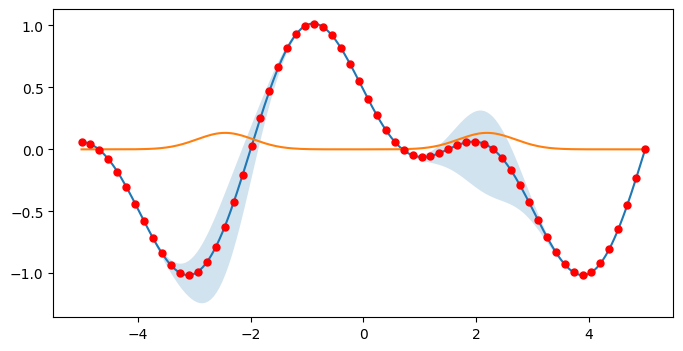

In [29]:
figure(figsize=(8,4))
xvals = linspace(-m, m, 201)
#plot(xvals, myf(xvals), alpha=0.5);
plot(xvals, mu(xvals), alpha=1);
plot(xvals, sig(xvals), alpha=1);
fill_between(xvals, mu(xvals)-3*sig(xvals), mu(xvals)+2*sig(xvals), alpha=0.2)
x_samples = linspace(-m, m, 64)
plot(x_samples, mu(x_samples), 'ro', ms=5);
#savefig('function_only.pdf');

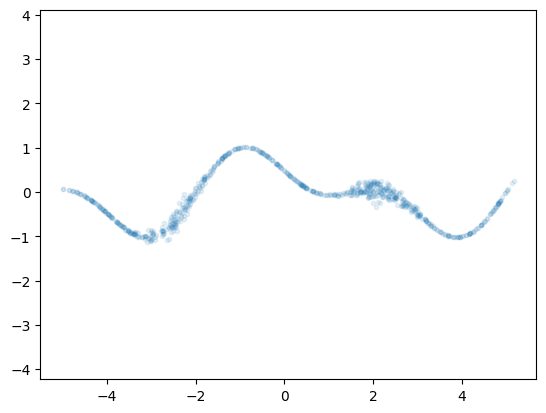

In [30]:
delta_s = 1.*m/64
delx = 0.01
xsamps = [-m]
xx = xsamps[0]
fsamps = [mu(xx)]

while xx<=m:
    dy = mu(xx+delx) - fsamps[-1]
    s = sqrt(delx**2 + dy**2)
    dx = delta_s * delx / (s)
    xx += dx
    n_samples = 2 #int(1. + 10*sig(xx))
    for k in range(n_samples):
        xn = xx + (1.+2.*random.normal())*dx
        f = sample(xn)
        xsamps.append(xn)
        fsamps.append(f)

xsamps = array(xsamps)
fsamps = array(fsamps)

plot(xsamps, fsamps, '.', alpha=0.1);
axis('equal');

In [31]:
import sklearn.cluster
fscale = 0.2
print(f'Suggested fscale = {sklearn.cluster.estimate_bandwidth(fsamps.reshape(-1,1))}')
xscale = fscale #sklearn.cluster.estimate_bandwidth(xsamps.reshape(-1,1))
print(f'xscale = {xscale}, fscale = {fscale}')

Suggested fscale = 0.32810861426189497
xscale = 0.2, fscale = 0.2


## Create the bundle

In [37]:
#N = len(A)
freq = 10.

#ds = SparsePhaseMap(M=5, N=N, sparsity=1)
ds = HexSSP(dtheta=5, nscales=120)

# xscale = 0.15
# fscale = 0.15

xaxis = ds.S[0]
faxis = ds.S[1]

N = len(ds.S[0])
print(f'Hypervector dimension: {N}')

Number of phasors: 2
Hypervector dimension: 8640


-5 0.2


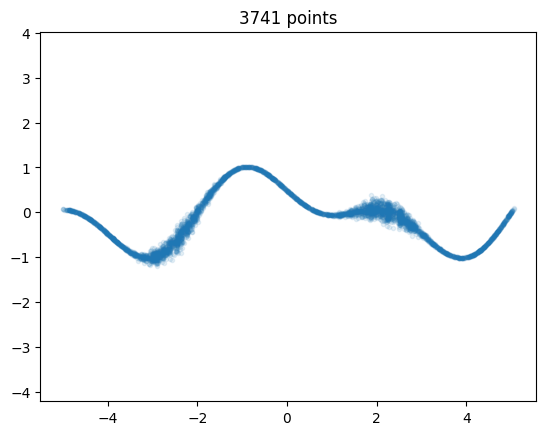

In [43]:
ds = 1.*m/200
delx = 0.01
xsamps = [-m]
xx = xsamps[0]
fsamps = [mu(xx)]

x = xaxis**(xx/xscale)
print(xx, xscale)
f = faxis**(mu(xx)/fscale)
fbundle = x*f

#fbundle = zeros(N, dtype=complex)
while xx<=m:
    dy = mu(xx+delx) - fsamps[-1]
    s = sqrt(delx**2 + dy**2)
    dx = ds * delx / (s)
    xx += dx
    n_samples = 4 #int(2. + 10*sig(xx))
    for k in range(n_samples):
        xn = xx + (1.+2.*random.normal())*dx
        f = sample(xn)
        xsamps.append(xn)
        fsamps.append(f)

        x = xaxis**(xn/xscale)
        f = faxis**(f/fscale)
        fbundle += x*f

mask = abs(fbundle)>0.5
fbundle[mask] /= abs(fbundle[mask])   # make it unitary
xsamps = array(xsamps)
fsamps = array(fsamps)

plot(xsamps, fsamps, '.', alpha=0.1);
title(f'{len(xsamps)} points'); axis('equal');
savefig('Gaussian_process.pdf')

## Analytical Performance

In [34]:
n_samples = 101
xrange = [-m,m]
frange = [-2, 2]
xvals = linspace(xrange[0], xrange[1], n_samples)
fvals = linspace(frange[0], frange[1], 401)

allfx = complex_similarity_2D(fbundle, [faxis, xaxis], fvals/fscale, xvals/xscale)

fx = []
for col in allfx.T:
    k = argmax(col)
    fx.append(fvals[k])
fx = array(fx)

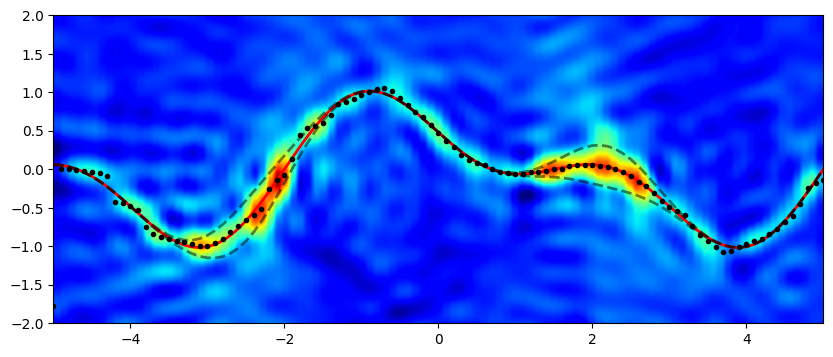

In [35]:
figure(figsize=(xrange[1]-xrange[0],frange[1]-frange[0]))
#imshow(relu(allfx.T-0.05), extent=(xrange[0],xrange[1],frange[0],frange[1]), origin='lower', cmap='jet')
#imshow(relu(allfx.T-0.1), origin='lower', cmap='hot')
imshow(allfx, extent=(xrange[0],xrange[1],frange[0],frange[1]), origin='lower', cmap='jet')
xxvals = linspace(-m, m, 401)
plot(xxvals, mu(xxvals), 'r', lw=2);
plot(xvals, fx, 'k.', mew=2, ms=4);
#fill_between(xvals, mu(xvals)-3*sig(xvals), mu(xvals)+2*sig(xvals), color='red', alpha=0.3);
plot(xvals, mu(xvals)-2*sig(xvals), 'k--', alpha=0.5, lw=2);
plot(xvals, mu(xvals)+2*sig(xvals), 'k--', alpha=0.5, lw=2);

## Create the network

In [38]:
net = SpikingPhasorNet()

F = GenerateSP(N=N, C=fbundle, freq=freq); net.add_pop(F)

# SSP for a location
xx = 0.4
X = GenerateSP(N=N, C=xaxis**(xx/xscale), freq=freq); net.add_pop(X)

# Now decode some values
z = PhaseDiffPop(N=N, freq=freq); net.add_pop(z)
net.deconvolve(F, X, z)

net.br.store()

In [39]:
net.total_neurons()

25920

In [40]:
n_samples = 101
xrange = [-m,m]
frange = [-2, 2]
xvals = linspace(xrange[0], xrange[1], n_samples)
fvals = linspace(frange[0], frange[1], 401)/fscale
fx = []
allfx = []
for xx in tqdm(xvals):
    net.br.restore()
    x = xaxis**(xx/xscale)
    X.set_spikes(C=x)
    net.run(0.2*second)
    max_i, sims = spatial_similarity(z, faxis, fvals, start_time=0.1)
    fx.append(fscale*fvals[max_i])
    allfx.append(sims)
allfx = array(allfx)

100%|████████████████████████████████████████████████████████████████████████████████████| 101/101 [01:06<00:00,  1.52it/s]


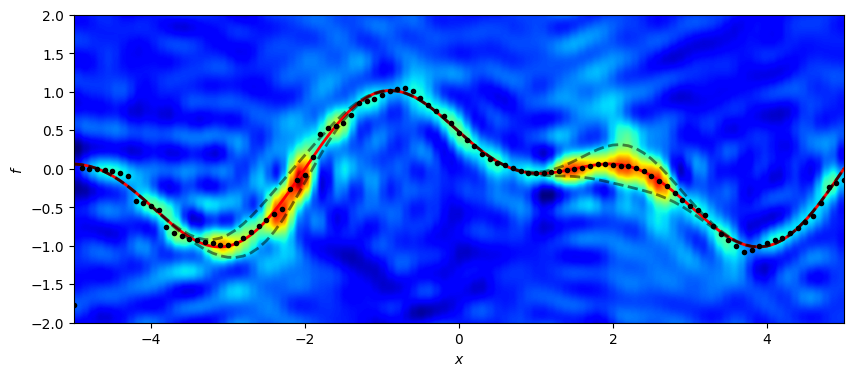

In [41]:
figure(figsize=(xrange[1]-xrange[0],frange[1]-frange[0]))
#imshow(relu(allfx.T-0.01), extent=(xrange[0],xrange[1],frange[0],frange[1]), origin='lower')
imshow(allfx.T, extent=(xrange[0],xrange[1],frange[0],frange[1]), origin='lower', cmap='jet')
xxvals = linspace(-m, m, 401)
plot(xxvals, mu(xxvals), 'r', lw=2);
plot(xvals, fx, 'k.', mew=2, ms=4);
plot(xvals, mu(xvals)-2*sig(xvals), 'k--', alpha=0.5, lw=2);
plot(xvals, mu(xvals)+2*sig(xvals), 'k--', alpha=0.5, lw=2);
xlabel(r'$x$'); ylabel(r'$f$');
savefig('function_bundle.pdf');